# SVR, RFR, KNN, LSTM, GRU

- https://www.kaggle.com/ysthehurricane/advanced-stock-pred-using-svr-rfr-knn-lstm-gru

## Import Libraries

In [56]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import os

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import cycle

import pickle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## Import Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Project1_Stock_Price/datasets3/pre_daehan.csv', encoding='cp949')
df.head()

,Date,Close,foreign,kospi,volatility,consumption,yield_bond,snp500,fng,gold,copper,wti,pork,usd_krw,cny_krw,eur_krw,jpy_krw,covid,weekday
0,2019-01-02,32400,1511066200,2010.00,19.00,1189.23,1214.51,2510.030029,30,46280.0,2.6795,46.54,61.70,112012.0,166.66,127061.0,10.2876,0.0,2
1,2019-01-03,31800,1595835650,1993.70,18.85,1179.03,1213.63,2447.889893,33,46760.0,2.6375,47.09,62.15,112589.0,166.66,128284.0,10.4573,0.0,3
2,2019-01-04,32350,2276971950,2010.25,18.15,1189.27,1213.69,2531.939941,48,46810.0,2.7095,47.96,61.95,111685.0,166.66,127265.0,10.2907,0.0,4
3,2019-01-07,33500,1751913500,2037.10,16.05,1192.68,1212.70,2549.689941,39,46690.0,2.6980,48.52,61.90,111766.0,166.66,128258.0,10.2806,0.0,0
4,2019-01-08,33900,2784345500,2025.27,15.95,1186.00,1211.56,2574.409912,39,46450.0,2.7230,49.78,62.60,112283.0,166.66,128474.0,10.3254,0.0,1


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

df.head()

,Date,Close,foreign,kospi,volatility,consumption,yield_bond,snp500,fng,gold,copper,wti,pork,usd_krw,cny_krw,eur_krw,jpy_krw,covid,weekday
0,2019-01-02,32400,1511066200,2010.00,19.00,1189.23,1214.51,2510.030029,30,46280.0,2.6795,46.54,61.70,112012.0,166.66,127061.0,10.2876,0.0,2
1,2019-01-03,31800,1595835650,1993.70,18.85,1179.03,1213.63,2447.889893,33,46760.0,2.6375,47.09,62.15,112589.0,166.66,128284.0,10.4573,0.0,3
2,2019-01-04,32350,2276971950,2010.25,18.15,1189.27,1213.69,2531.939941,48,46810.0,2.7095,47.96,61.95,111685.0,166.66,127265.0,10.2907,0.0,4
3,2019-01-07,33500,1751913500,2037.10,16.05,1192.68,1212.70,2549.689941,39,46690.0,2.6980,48.52,61.90,111766.0,166.66,128258.0,10.2806,0.0,0
4,2019-01-08,33900,2784345500,2025.27,15.95,1186.00,1211.56,2574.409912,39,46450.0,2.7230,49.78,62.60,112283.0,166.66,128474.0,10.3254,0.0,1


In [4]:
df.shape

(741, 19)

## EDA

### Get the duration of dataset

In [5]:
print("Starting date: ", df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0] - df.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2021-12-30 00:00:00
Duration:  1093 days 00:00:00


### Trend 비교

In [ ]:
# names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

# fig = px.line(df, x=df.Date, y=[df['open'], df['close'], 
#                                           df['high'], df['low']],
#              labels={'date': 'Date','value':'Stock value'})
# fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
# fig.for_each_trace(lambda t:  t.update(name = next(names)))
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)

# fig.show()

## Close price prediction preparation and preprocessing

In [6]:
closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (741, 2)


In [7]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Normalizing/Scaling

In [8]:
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(741, 1)


### Split Data for Training and Testing(70:30)

In [9]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (518, 1)
test_data:  (223, 1)


### New Dataset according to requirement of time-series prediction

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (502, 15)
y_train:  (502,)
X_test:  (207, 15)
y_test (207,)


## SVR

In [14]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/SVR_model.pkl'
pickle.dump(svr_rbf, open(filename, 'wb'))

# loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (502, 1)
Test data prediction: (207, 1)


### Prediction

In [16]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [17]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  922.8108926073819
Train data MSE:  851579.943514833
Test data MAE:  702.7805224751526
-------------------------------------------------------------------------------------
Test data RMSE:  836.5031999983822
Test data MSE:  699737.6036075334
Test data MAE:  691.4790941761987


In [18]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9730102968857695
Test data explained variance regression score: 0.879367789086939


In [19]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9729540725882139
Test data R2 score: 0.831631518966159


In [20]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0014836114389022664
Test data MGD:  0.0007560992539757847
----------------------------------------------------------------------
Train data MPD:  34.345809086519616
Test data MPD:  22.958896080992524


### Comparision bw original vs predicted values

In [21]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [22]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = svr_rbf.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = svr_rbf.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [23]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [24]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [26]:
svrdf=closedf.tolist()
svrdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
svrdf=scaler.inverse_transform(svrdf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(svrdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Random Forest Regressor

In [53]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/RF_model.pkl'
pickle.dump(regressor, open(filename, 'wb'))

### Prediction

In [28]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (502, 1)
Test data prediction: (207, 1)


In [29]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [30]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  291.40664657028447
Train data MSE:  84917.8336653387
Test data MAE:  195.66533864541896
-------------------------------------------------------------------------------------
Test data RMSE:  664.6138512369705
Test data MSE:  441711.571256038
Test data MAE:  496.3405797101442


In [31]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9973034549053061
Test data explained variance regression score: 0.8946685795458711


In [32]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9973030346912592
Test data R2 score: 0.8937168648304301


In [33]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00015066787800249528
Test data MGD:  0.00048714619727222675
----------------------------------------------------------------------
Train data MPD:  3.447037172578935
Test data MPD:  14.639602674161345


### Comparision bw original vs predicted values

In [34]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [35]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [36]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [37]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [38]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## KNN

In [52]:
from sklearn import neighbors

K = time_step # 15
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/KNN_model.pkl'
pickle.dump(neighbor, open(filename, 'wb'))

### Prediction

In [40]:
train_predict=neighbor.predict(X_train)
test_predict=neighbor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (502, 1)
Test data prediction: (207, 1)


In [41]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [42]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  974.35355580215
Train data MSE:  949364.8517042935
Test data MAE:  682.8419654714475
-------------------------------------------------------------------------------------
Test data RMSE:  1009.9263909232196
Test data MSE:  1019951.3150831998
Test data MAE:  795.8615136876008


In [43]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9698913377353561
Test data explained variance regression score: 0.8048470084945256


In [44]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9698484527940879
Test data R2 score: 0.7545827853702929


In [45]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.001726408833453729
Test data MGD:  0.001169795526891562
----------------------------------------------------------------------
Train data MPD:  39.33704342156671
Test data MPD:  34.48182181560081


### Comparision bw original vs predicted values

In [46]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [47]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = neighbor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [48]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [49]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [50]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(knndf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## LSTM

In [51]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (502, 15, 1)
X_test:  (207, 15, 1)


In [58]:
tf.keras.backend.clear_session()

model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [59]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history_lstm = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1, callbacks=[early_stopping_callback])

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/LSTM_model.pkl'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/200
101/101 [==============================] - 8s 32ms/step - loss: 0.0281 - val_loss: 0.0055
Epoch 2/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 3/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 4/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 5/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 7/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 8/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 9/200
101/101 [==============================] - 2s 20ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 10/200
101/101 [==============================] - 2s 20ms/step - loss: 0.003

INFO:tensorflow:Assets written to: ram://b476a315-ce79-4d6f-a76e-9da0fe39ed68/assets


INFO:tensorflow:Assets written to: ram://b476a315-ce79-4d6f-a76e-9da0fe39ed68/assets


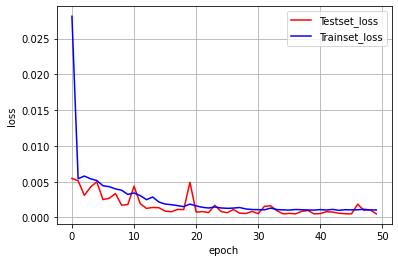

In [66]:
# 테스트셋의 오차
y_vloss = history_lstm.history['val_loss']

# 트레인셋의 오차
y_loss = history_lstm.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c='red', label="Testset_loss")
plt.plot(x_len, y_loss, c='blue', label="Trainset_loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Prediction

In [63]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((502, 1), (207, 1))

In [67]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [68]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  699.1423947753937
Train data MSE:  488800.0881722724
Test data MAE:  477.7026756256226
-------------------------------------------------------------------------------------
Test data RMSE:  541.2620638472284
Test data MSE:  292964.62176016124
Test data MAE:  395.9953200483092


In [69]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9844782184340625
Test data explained variance regression score: 0.9301154179407245


In [70]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9844758536127364
Test data R2 score: 0.9295078496451965


In [71]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0008796534108619721
Test data MGD:  0.0003258878807373317
----------------------------------------------------------------------
Train data MPD:  20.092962157321207
Test data MPD:  9.748898582906959


### Comparision bw original vs predicted values

In [72]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [74]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [75]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [76]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [77]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## GRU

In [78]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (502, 15, 1)
X_test:  (207, 15, 1)


In [79]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________


In [80]:
history_gru = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1, callbacks=[early_stopping_callback])

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/GRU_model.pkl'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/200
101/101 [==============================] - 20s 77ms/step - loss: 0.0185 - val_loss: 0.0020
Epoch 2/200
101/101 [==============================] - 5s 45ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/200
101/101 [==============================] - 6s 60ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 4/200
101/101 [==============================] - 5s 46ms/step - loss: 0.0023 - val_loss: 9.6032e-04
Epoch 5/200
101/101 [==============================] - 6s 56ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 6/200
101/101 [==============================] - 5s 49ms/step - loss: 0.0020 - val_loss: 8.7549e-04
Epoch 7/200
101/101 [==============================] - 5s 46ms/step - loss: 0.0016 - val_loss: 8.0089e-04
Epoch 8/200
101/101 [==============================] - 3s 32ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/200
101/101 [==============================] - 3s 31ms/step - loss: 0.0018 - val_loss: 7.2529e-04
Epoch 10/200
101/101 [==============================] - 3s 31ms/s

INFO:tensorflow:Assets written to: ram://73c9e59e-1ff1-4a95-a008-8656eb84d5c5/assets


INFO:tensorflow:Assets written to: ram://73c9e59e-1ff1-4a95-a008-8656eb84d5c5/assets


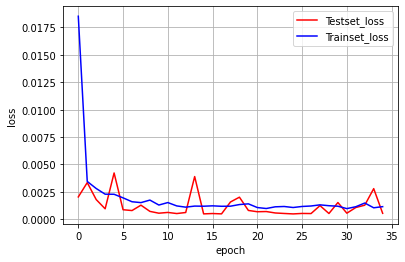

In [81]:
# 테스트셋의 오차
y_vloss = history_gru.history['val_loss']

# 트레인셋의 오차
y_loss = history_gru.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c='red', label="Testset_loss")
plt.plot(x_len, y_loss, c='blue', label="Trainset_loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Prediction

In [82]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((502, 1), (207, 1))

In [83]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [84]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  716.2253933764187
Train data MSE:  512978.8141172056
Test data MAE:  498.1085871358317
-------------------------------------------------------------------------------------
Test data RMSE:  565.9937340057493
Test data MSE:  320348.90693377086
Test data MAE:  434.3666213768118


In [85]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9846119676841578
Test data explained variance regression score: 0.9291067283362336


In [86]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9837079444201865
Test data R2 score: 0.9229187361330632


In [87]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0009139763580814736
Test data MGD:  0.0003532729163937253
----------------------------------------------------------------------
Train data MPD:  20.952126216840803
Test data MPD:  10.613491632580697


### Comparision bw original vs predicted values

In [88]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [89]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [90]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [91]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [92]:
grudf=closedf.tolist()
grudf.extend((np.array(lst_output).reshape(-1,1)).tolist())
grudf=scaler.inverse_transform(grudf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(grudf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## LSTM + GRU

In [93]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (502, 15, 1)
X_test:  (207, 15, 1)


In [94]:
tf.keras.backend.clear_session()

model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 gru (GRU)                   (None, 15, 32)            6336      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25,377
Trainable params: 25,377
Non-trainable params: 0
_________________________________________________________________


In [95]:
history_lstmgru = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1, callbacks=[early_stopping_callback])

# save model
filename = '/content/drive/MyDrive/Project1_Stock_Price/Modeling/models/lstmgru_model.pkl'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/200
101/101 [==============================] - 18s 45ms/step - loss: 0.0186 - val_loss: 0.0037
Epoch 2/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 3/200
101/101 [==============================] - 3s 30ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 4/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 5/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 6/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 8/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 9/200
101/101 [==============================] - 3s 29ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/200
101/101 [==============================] - 3s 29ms/step - loss: 0.00

INFO:tensorflow:Assets written to: ram://675bc0c6-b299-416f-8499-0fc395f18e49/assets


INFO:tensorflow:Assets written to: ram://675bc0c6-b299-416f-8499-0fc395f18e49/assets


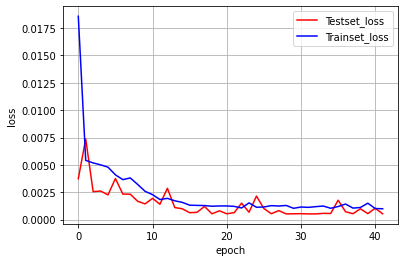

In [96]:
# 테스트셋의 오차
y_vloss = history_lstmgru.history['val_loss']

# 트레인셋의 오차
y_loss = history_lstmgru.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c='red', label="Testset_loss")
plt.plot(x_len, y_loss, c='blue', label="Trainset_loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Prediction

In [97]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((502, 1), (207, 1))

In [98]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation

In [99]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  711.2133272700604
Train data MSE:  505824.39688655
Test data MAE:  491.7052979488297
-------------------------------------------------------------------------------------
Test data RMSE:  557.4155483421797
Test data MSE:  310712.09353361285
Test data MAE:  397.5131529287441


In [100]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9845306975670549
Test data explained variance regression score: 0.9279412942064087


In [101]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.983935166597702
Test data R2 score: 0.9252375133801714


In [102]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0009337141927941928
Test data MGD:  0.00034999916355597544
----------------------------------------------------------------------
Train data MPD:  21.011313784044464
Test data MPD:  10.402895259138784


### Comparision bw original vs predicted values

In [103]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


### Predicting next 10 days

In [104]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


### Plotting last 15 days and next predicted 10 days

In [105]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [106]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Plotting whole closing stock price with prediction

In [107]:
lstmgrudf=closedf.tolist()
lstmgrudf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmgrudf=scaler.inverse_transform(lstmgrudf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(lstmgrudf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Summary

In [108]:
finaldf = pd.DataFrame({
    'svr':svrdf,
    'rf':rfdf,
    'knn':knndf,
    'lstm':lstmdf,
    'gru':grudf,
    'lstm_gru':lstmgrudf,
})
finaldf.head()

,svr,rf,knn,lstm,gru,lstm_gru
0,32400.0,32400.0,32400.0,32400.0,32400.0,32400.0
1,31800.0,31800.0,31800.0,31800.0,31800.0,31800.0
2,32350.0,32350.0,32350.0,32350.0,32350.0,32350.0
3,33500.0,33500.0,33500.0,33500.0,33500.0,33500.0
4,33900.0,33900.0,33900.0,33900.0,33900.0,33900.0


In [109]:
finaldf.tail()

,svr,rf,knn,lstm,gru,lstm_gru
746,31353.679754,28314.0,27713.333333,29834.259623,30335.917342,28714.537129
747,32005.018003,28258.0,27713.333333,29912.731358,30503.102514,28590.547037
748,32328.383113,28382.0,27636.666667,29991.080740,30670.697930,28469.306299
749,32220.932651,28398.5,27626.666667,30068.746382,30838.536614,28351.344633
750,32490.005078,28378.5,27536.666667,30144.886205,31006.523561,28235.796928


In [110]:
names = cycle(['SVR', 'RF','KNN','LSTM','GRU','LSTM + GRU'])

fig = px.line(finaldf[225:], x=finaldf.index[225:], y=[finaldf['svr'][225:],finaldf['rf'][225:], finaldf['knn'][225:], 
                                          finaldf['lstm'][225:], finaldf['gru'][225:], finaldf['lstm_gru'][225:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()